In [1]:
include("./runSim.jl")
pwd()

"/home/javier/Projects/DiffSolver"

In [72]:
α₁, _ = genInitialCond(512, 5, true)
gMx, gMy = gen_op(size(α₁,1), true)        # This generates the discrete laplacian as in CR's tutorial
r1 = 1.0/400.0
Dd = 1.0
if true
    gMyA = CuArray(Float32.(zeros(size(gMx))))
    gAMx = CuArray(Float32.(zeros(size(gMx))))
    gDA = CuArray(Float32.(zeros(size(gMx))))
else
    gMyA = zeros(size(gMx))
    gAMx = zeros(size(gMx))
    gDA = zeros(size(gMx))
end
u0 = α₁

512×512 CuArray{Float32, 2, CUDA.Mem.DeviceBuffer}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0

In [3]:
function genTuples(idx, in_cond, dist, use_gpu; s=100, radius=5, tmax=3000.0,
            dir = "newdata")
  α₁ = in_cond
  u0 = α₁
  if use_gpu
      prob = ODEProblem{false}(f,u0,(0.0,tmax),α₁)
#       @time sol = solve(prob,ROCK2(),progress=true,save_everystep=true,save_start=true)
    sol = solve(prob,ROCK2(),progress=true,save_everystep=true,save_start=true)
  else
      prob = ODEProblem{false}(fCPU,u0,(0.0,tmax),α₁)
#       @time sol = solve(prob,ROCK2(),save_everystep=false,save_start=false, abstol = 1e-3, reltol = 1e-3)
    sol = solve(prob,ROCK2(),save_everystep=false,save_start=false, abstol = 1e-3, reltol = 1e-3)
  end
  out = Array(sol[end])/maximum(sol[end])    #radius^2

#   path = PATH * dir * "/test2"   # temp: remove test2
#   isdir(path) || mkpath(path)
#   writedlm(path * "/Cell_$idx.dat", reshape(Array(α₁),:))
#   writedlm(path * "/Field_$idx.dat", reshape(out,:))
  # writedlm(path * "/Dist_$idx.dat", dist)
  Array(α₁), out
end

function runFunction(start, stop, dir; ns=1, gridSize=100, radius = 5)
  for i in start:stop
    @info i
    in_cond, dist = genInitialCond(gridSize, r, use_gpu; ns=ns)
    init_cond, final_state = genTuples(i, in_cond, dist, use_gpu; dir=dir)
    # f1 = heatmap(init_cond)
    # f2 = heatmap(final_state)
    # fig = plot(f1,f2, layout = @layout grid(2,1))
    # display(fig)
    CUDA.reclaim()
    if log
        flush(io)
    end
  end
end

runFunction (generic function with 1 method)

In [4]:
function genInitialCond(s, radius, use_gpu; ns=1, pos=[50 50])
  ar = [[i,j] for i in 1:s, j in 1:s]
  dist = zeros(ns)
  init_cond = zeros(s,s)
  for ns0 in 1:ns
    if size(pos,1) != 0
        source = [pos[ns0,1], pos[ns0,2]]
    else
        source = [rand(radius:s-radius), rand(radius:s-radius)]
    end
    dist[ns0] = min_dist_to_border(source, s)
    init_cond = init_cond .+ [in_source(ar[i,j][1], source[1], ar[i,j][2], source[2], radius) for i in 1:s, j in 1:s] .* rand(0.01:0.0000001:1.0)
  end

  if use_gpu
      CuArray{Float32,2}(init_cond/maximum(init_cond)), dist
  else
      init_cond/maximum(init_cond), dist
  end
#   CuArray{Float32,2}(min.(init_cond,1.0)), dist
end

genInitialCond (generic function with 1 method)

In [5]:
256-94

162

In [67]:
in_cond, dist = genInitialCond(512, 20, true; ns=9, pos=[256 256; 306 306; 212 306; 212 212; 312 212; 256 326; 256 196; 326 256; 196 256])
a,b = genTuples(1, in_cond, dist, true)

(Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], Float32[-5.922513f-14 -3.3984174f-16 … -1.6602127f-14 -5.4508806f-14; 7.223496f-16 3.239698f-14 … 1.6321871f-14 1.0047011f-14; … ; -1.4537537f-14 3.8657117f-14 … -4.8826645f-14 -5.459133f-14; -4.844318f-14 4.13702f-14 … -5.716212f-14 -7.862855f-14])

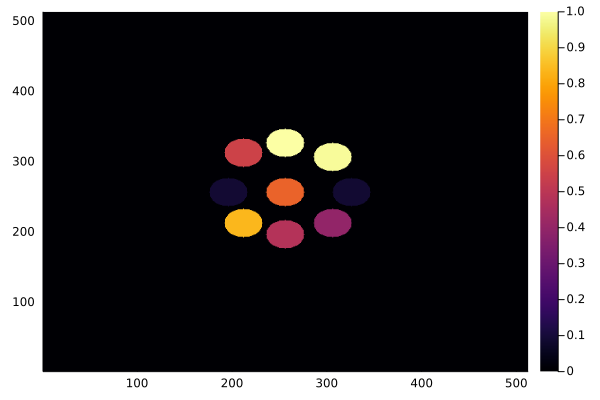

In [68]:
heatmap(Array(a))

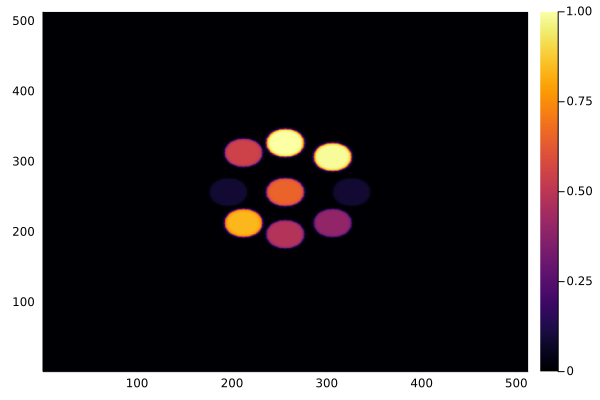

In [69]:
heatmap(Array(b))

In [20]:
sqrt(2)*512

724.0773439350247

In [70]:
α₁ = in_cond
u0 = α₁
#   if use_gpu
# prob = ODEProblem{false}(f,u0,(0.0,tmax),α₁)
# sol = solve(prob,ROCK2(),progress=true,save_everystep=true,save_start=true)
#   else
prob = ODEProblem{false}(f,u0,(0.0,2000.0),α₁)
sol = solve(prob,ROCK2(),save_everystep=false,save_start=false, abstol = 1e-3, reltol = 1e-3)

out = Array(sol[end])#/maximum(sol[end])    #radius^2

512×512 Matrix{Float32}:
  1.18365f-9    2.08418f-10  -1.16601f-9   …   1.9468f-10    3.94031f-10
  2.08418f-10  -5.00427f-11  -2.29336f-10      1.08169f-10  -9.99575f-11
 -1.16601f-9   -2.29336f-10   1.10487f-9      -9.81336f-11  -3.36506f-10
 -4.75684f-10   2.87273f-11   4.33861f-10     -1.7829f-10    2.15544f-10
  9.89672f-10   1.74984f-10  -9.44517f-10     -9.19634f-11   2.28209f-10
  7.01757f-10   1.92226f-11  -5.48398f-10  …   1.28974f-10  -3.75742f-10
 -5.5294f-10    1.50032f-11   6.71163f-10      2.87169f-10  -1.39918f-10
 -6.45498f-10   5.6027f-11    4.99745f-10      8.96101f-11   5.51981f-10
 -1.45875f-12  -2.12823f-10  -3.38703f-10     -2.97745f-10   1.96432f-10
  1.76041f-10  -3.17573f-10  -2.90819f-10     -3.50217f-10  -5.67168f-10
  3.12074f-10   1.37606f-10   2.41295f-11  …   1.2066f-11   -4.13403f-10
  4.49548f-10   5.24016f-10   2.21411f-11      3.6349f-10    1.85011f-10
 -1.67395f-10   3.09307f-10   2.51416f-10      3.6025f-10    5.32738f-10
  ⋮                       

In [71]:
heatmap(Array(out))
maximum(out)

1.0078671f0

In [64]:
sqrt(r1/Dd) * pi * 20 / maximum(out)

7.208991456291373

In [46]:
using Statistics
mean(Array(out)/maximum(Array(out))-Array(b))

-2.3730436f-6

In [11]:
# probCPU = ODEProblem{false}(f,u0,(0.0,20000.0),α₁)
# probSteady = SteadyStateProblem(probCPU)
# sol2 = solve(probSteady,DynamicSS(Tsit5()),save_everystep=false,save_start=false)

LoadError: InterruptException:

In [38]:
# SteadyStateProblem(f,u0,α₁)
# sol2=SteadyStateProblem{isinplace}(f,u0,α₁)

SteadyStateProblem with uType CuArray{Float32, 2, CUDA.Mem.DeviceBuffer}. In-place: isinplace
u0: 512×512 CuArray{Float32, 2, CUDA.Mem.DeviceBuffer}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0